In [6]:
import wandb
import re

api = wandb.Api()

project = "adaptive_rank_allocation"
entity = "mallahova"

runs = api.runs(f"{entity}/{project}")

run_max_metrics = []

for run in runs:
    # Check for specific naming pattern
    if run.name[-2:] == "20":  # Adjust the condition to your needs
        # Extract seed and history
        seed = run.config.get("seed", "N/A")
        run_history = run.history()
        rank_metrics = "eval/matthews_correlation"

        # Regex pattern to parse run name
        pattern = r"results_(?P<task>[a-zA-Z0-9]+)_(?P<rank_min>[\d.]+)_(?P<rank_max>[\d.]+)_(?P<alpha_min>[\d.]+)_(?P<alpha_max>[\d.]+)_(?P<seed>\d+)_(?P<lr>[\d.]+)_(?P<rank_avg>[\d.]+)"
        match = re.match(pattern, run.name)

        if match and rank_metrics:
            # Extract components from the run name
            task = match.group("task")
            rank_min = float(match.group("rank_min"))
            rank_max = float(match.group("rank_max"))
            alpha_min = float(match.group("alpha_min"))
            alpha_max = float(match.group("alpha_max"))
            seed = int(match.group("seed"))
            rank_allocation_learning_rate = float(match.group("lr"))
            rank_average = float(match.group("rank_avg"))

            # Get the overall max of the rank metrics
            overall_max = run.history(keys=[rank_metrics])[rank_metrics].max() * 100

            # Append parsed data to run_max_metrics
            run_max_metrics.append({
                "run_name": run.name,
                "task": task,
                "rank_min": rank_min,
                "rank_max": rank_max,
                "alpha_min": alpha_min,
                "alpha_max": alpha_max,
                "rank_allocation_learning_rate": rank_allocation_learning_rate,
                "rank_average": rank_average,
                "seed": seed,
                "overall_max": overall_max
            })

In [7]:
# Sort the results by rank allocation learning rate and seed
sorted_results = sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

# Print the results
for result in sorted_results:
    print(f"Run Name: {result['run_name']}")
    print(f"Task: {result['task']}, Rank Min: {result['rank_min']}, Rank Max: {result['rank_max']}, "
          f"Rank Allocation Learning Rate: {result['rank_allocation_learning_rate']}, Rank Average: {result['rank_average']},"
          f"Alpha Min: {result['alpha_min']}, Alpha Max: {result['alpha_max']}, Seed: {result['seed']} "
          )
    print(f"Overall Max: {result['overall_max']:.2f}\n")


Run Name: results_cola_15_25_0.5_3_3_0.01_20
Task: cola, Rank Min: 15.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.01, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 3 
Overall Max: 69.90

Run Name: results_cola_15_25_0.5_3_3_0.002_20
Task: cola, Rank Min: 15.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.002, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 3 
Overall Max: 68.70

Run Name: results_cola_5_25_0.5_3_3_0.02_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.02, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 3 
Overall Max: 68.59

Run Name: results_cola_5_35_0.5_3_3_0.02_20
Task: cola, Rank Min: 5.0, Rank Max: 35.0, Rank Allocation Learning Rate: 0.02, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 3 
Overall Max: 68.40

Run Name: results_cola_15_35_0.5_3_3_0.01_20
Task: cola, Rank Min: 15.0, Rank Max: 35.0, Rank Allocation Learning Rate: 0.01, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, S

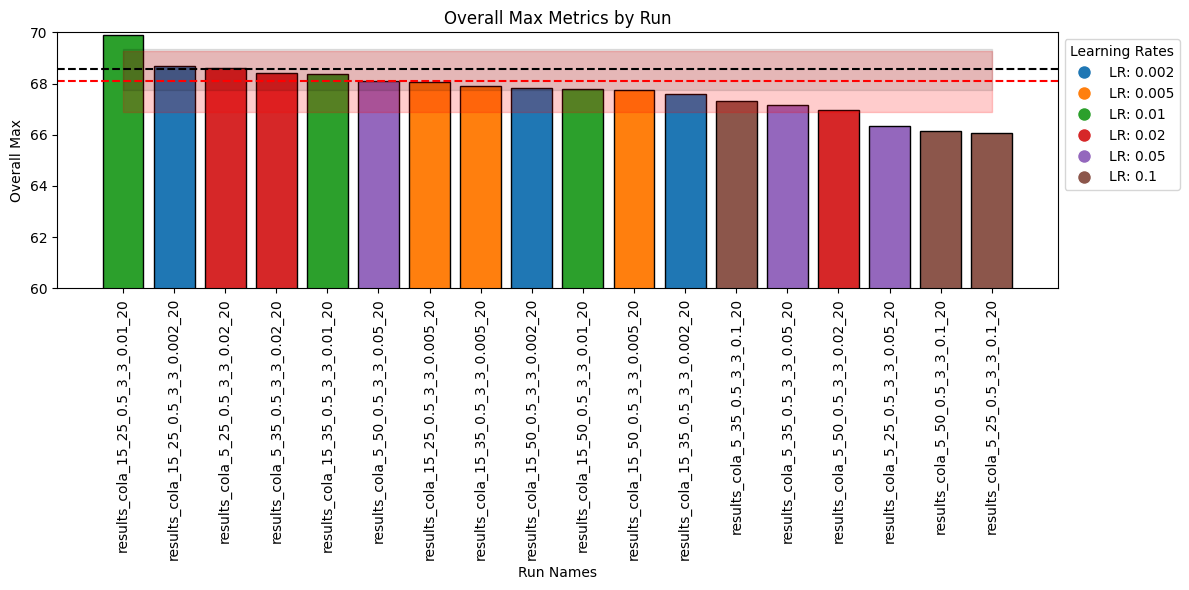

In [8]:

import matplotlib.pyplot as plt
import numpy as np

# Assume run_max_metrics contains the data
sorted_results = sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

# Extract data for plotting
run_names = [result['run_name'] for result in sorted_results]
overall_max = [result['overall_max'] for result in sorted_results]
learning_rates = [result['rank_allocation_learning_rate'] for result in sorted_results]

# Define baseline and its error
baseline_median = 68.08
baseline_std = 1.21

# Assign colors based on unique learning rates
unique_lrs = sorted(set(learning_rates))
color_map = {lr: plt.cm.tab10(i % 10) for i, lr in enumerate(unique_lrs)}
colors = [color_map[lr] for lr in learning_rates]

# Plotting the bar plot
plt.figure(figsize=(12, 6))
bar_positions = np.arange(len(run_names))
plt.bar(bar_positions, overall_max, color=colors, edgecolor='black')

rank_25_mediean=68.55
rank_25_std=0.81

# Add baseline with shading for std
plt.axhline(baseline_median, color='red', linestyle='--', label=f'Baseline: {baseline_median:.2f}')
plt.axhline(rank_25_mediean, color='black', linestyle='--', label=f'Baseline: {rank_25_mediean:.2f}')

plt.fill_between(bar_positions, baseline_median - baseline_std, baseline_median + baseline_std, color='red', alpha=0.2, label=f'Baseline ± std')
plt.fill_between(bar_positions, rank_25_mediean - rank_25_std, rank_25_mediean + rank_25_std, color='black', alpha=0.1, label=f'Rank 25 ± std')

# Adding labels and legend
plt.xticks(bar_positions, run_names, rotation=90)
plt.xlabel('Run Names')
plt.ylabel('Overall Max')
plt.title('Overall Max Metrics by Run')

# Create legend for learning rates
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'LR: {lr}', markerfacecolor=color_map[lr], markersize=10) for lr in unique_lrs]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Learning Rates")
plt.ylim(60, 70)  # Adjust the upper limit if needed

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Find the run with the highest overall max
best_run = max(run_max_metrics, key=lambda x: x["overall_max"])
print(best_run)
best_run = next(run for run in runs if run.name == best_run["run_name"])
rank_metrics = "eval/matthews_correlation"
keys=[rank_metrics, '_step']
# rank_allocation_keys=[f'train/rank_allocation_{i}' for i in range(0, 96)]
# keys.extend(rank_allocation_keys)
history=best_run.scan_history(keys=keys, page_size=1000)

history_df = pd.DataFrame(history)

# Display the DataFrame
print(history_df)
    # history = best_run.history(keys=[rank_metrics], pandas=True)

# # Define the metrics you want to fetch
# keys_to_fetch = ["train/loss", "eval/matthews_correlation"]

# # Fetch the full history for these keys
# history = best_run.history(keys=keys_to_fetch, pandas=True)

# # Display the first few rows to confirm
# print(history.head())

# max_row = best_run_history[best_run_history[rank_metrics] == best_run_history[rank_metrics].max()]
# max_row

 # Get the step when the overall max occurred
# # Assuming you have the history object from the run

# # Retrieve the global_step at that point
# global_step_at_max = run.history(keys=['train/global_step'])['train/global_step'][step_of_max]
# print(global_step_at_max)
# # Bar plot for train/rank_allocation_{i} at the step of max
# rank_keys = [key for key in best_run_history.columns if key.startswith("train/rank_allocation_")]
# # Create a DataFrame for the rank allocations at the step of max
# print(best_run_history[best_run_history['train/global_step'] == global_step_at_max][rank_metrics].values[0])
# rank_allocations = {
#     key: best_run_history[best_run_history['train/global_step'] == global_step_at_max][key].values[0]
#     for key in rank_keys
# }

# # Convert to DataFrame for plotting
# df = pd.DataFrame(rank_allocations.items(), columns=["Rank", "Value"])
# df["Rank"] = df["Rank"].str.replace("train/rank_allocation_", "").astype(int)

# # Sort by rank
# df.sort_values(by="Rank", inplace=True)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.bar(df["Rank"], df["Value"], color="skyblue")
# plt.xlabel("Rank Index")
# plt.ylabel("Value")
# plt.title(f"Rank Allocation at Step {step_of_max} (Run: {best_run['run_name']})")
# plt.xticks(df["Rank"])
# plt.tight_layout()
# plt.show()

: 

In [ ]:
history_df

: 

## Observations
At the beginning of the training (first 2 epochs), the ranks for first 33% of the layers are getting lower, while the ranks for 33% tend to get higher.

 <img src="assets/rank_allocation_beginning.png" alt=“LoRA-XS” width=90%>

In [3]:
import wandb
import re

api = wandb.Api()

project = "adaptive_rank_allocation_l_r"
entity = "mallahova"

runs = api.runs(f"{entity}/{project}")

run_max_metrics = []

for run in runs:
    # Check for specific naming pattern
    if run.name[-2:] == "20":  # Adjust the condition to your needs
        # Extract seed and history
        seed = run.config.get("seed", "N/A")
        run_history = run.history()
        rank_metrics = "eval/matthews_correlation"

        # Regex pattern to parse run name
        pattern = r"results_(?P<task>[a-zA-Z0-9]+)_(?P<rank_min>[\d.]+)_(?P<rank_max>[\d.]+)_(?P<alpha_min>[\d.]+)_(?P<alpha_max>[\d.]+)_(?P<seed>\d+)_(?P<lr>[\d.]+)_(?P<rank_avg>[\d.]+)"
        match = re.match(pattern, run.name)

        if match and rank_metrics:
            # Extract components from the run name
            task = match.group("task")
            rank_min = float(match.group("rank_min"))
            rank_max = float(match.group("rank_max"))
            alpha_min = float(match.group("alpha_min"))
            alpha_max = float(match.group("alpha_max"))
            seed = int(match.group("seed"))
            rank_allocation_learning_rate = float(match.group("lr"))
            rank_average = float(match.group("rank_avg"))

            # Get the overall max of the rank metrics
            overall_max = run.history(keys=[rank_metrics])[rank_metrics].max() * 100

            # Append parsed data to run_max_metrics
            run_max_metrics.append({
                "run_name": run.name,
                "task": task,
                "rank_min": rank_min,
                "rank_max": rank_max,
                "alpha_min": alpha_min,
                "alpha_max": alpha_max,
                "rank_allocation_learning_rate": rank_allocation_learning_rate,
                "rank_average": rank_average,
                "seed": seed,
                "overall_max": overall_max
            })

In [4]:
# Sort the results by rank allocation learning rate and seed
sorted_results = sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

# Print the results
for result in sorted_results:
    print(f"Run Name: {result['run_name']}")
    print(f"Task: {result['task']}, Rank Min: {result['rank_min']}, Rank Max: {result['rank_max']}, "
          f"Rank Allocation Learning Rate: {result['rank_allocation_learning_rate']}, Rank Average: {result['rank_average']},"
          f"Alpha Min: {result['alpha_min']}, Alpha Max: {result['alpha_max']}, Seed: {result['seed']} "
          )
    print(f"Overall Max: {result['overall_max']:.2f}\n")


Run Name: results_cola_5_25_0.5_3_5_0.01_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.01, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 5 
Overall Max: 69.30

Run Name: results_cola_5_25_0.5_3_9_0.02_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.02, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 9 
Overall Max: 68.30

Run Name: results_cola_5_25_0.5_3_9_0.01_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.01, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 9 
Overall Max: 68.05

Run Name: results_cola_5_25_0.5_3_5_0.02_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.02, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 5 
Overall Max: 68.01

Run Name: results_cola_5_25_0.5_3_4_0.02_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.02, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 4 


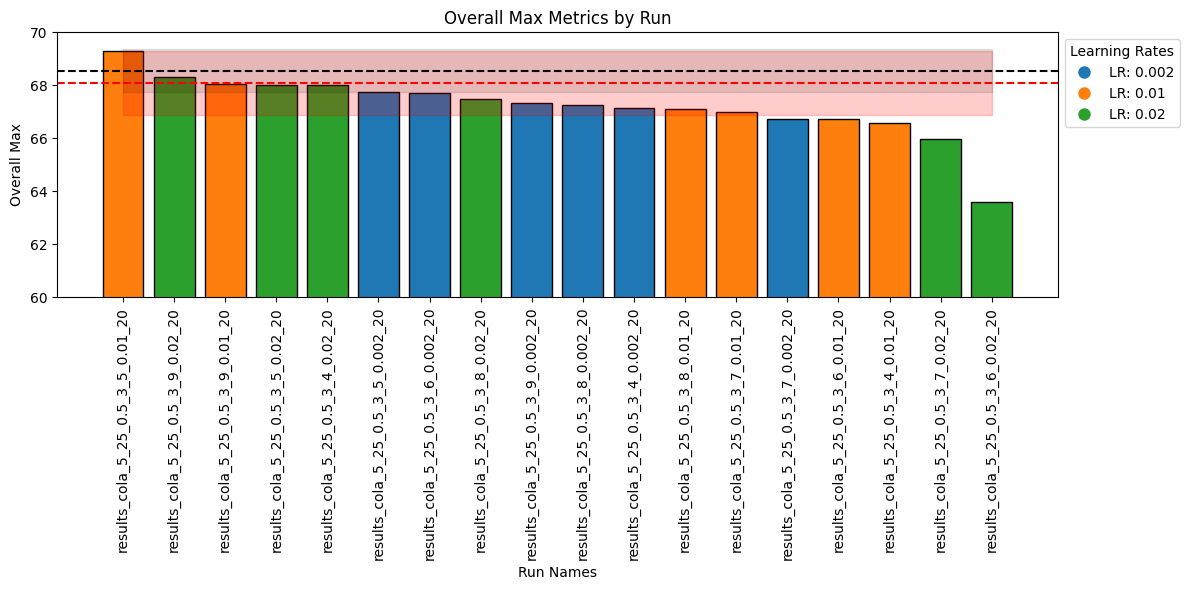

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# Assume run_max_metrics contains the data
sorted_results = sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

# Extract data for plotting
run_names = [result['run_name'] for result in sorted_results]
overall_max = [result['overall_max'] for result in sorted_results]
learning_rates = [result['rank_allocation_learning_rate'] for result in sorted_results]

# Define baseline and its error
baseline_median = 68.08
baseline_std = 1.21

# Assign colors based on unique learning rates
unique_lrs = sorted(set(learning_rates))
color_map = {lr: plt.cm.tab10(i % 10) for i, lr in enumerate(unique_lrs)}
colors = [color_map[lr] for lr in learning_rates]

# Plotting the bar plot
plt.figure(figsize=(12, 6))
bar_positions = np.arange(len(run_names))
plt.bar(bar_positions, overall_max, color=colors, edgecolor='black')

rank_25_mediean=68.55
rank_25_std=0.81

# Add baseline with shading for std
plt.axhline(baseline_median, color='red', linestyle='--', label=f'Baseline: {baseline_median:.2f}')
plt.axhline(rank_25_mediean, color='black', linestyle='--', label=f'Baseline: {rank_25_mediean:.2f}')

plt.fill_between(bar_positions, baseline_median - baseline_std, baseline_median + baseline_std, color='red', alpha=0.2, label=f'Baseline ± std')
plt.fill_between(bar_positions, rank_25_mediean - rank_25_std, rank_25_mediean + rank_25_std, color='black', alpha=0.1, label=f'Rank 25 ± std')

# Adding labels and legend
plt.xticks(bar_positions, run_names, rotation=90)
plt.xlabel('Run Names')
plt.ylabel('Overall Max')
plt.title('Overall Max Metrics by Run')

# Create legend for learning rates
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'LR: {lr}', markerfacecolor=color_map[lr], markersize=10) for lr in unique_lrs]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Learning Rates")
plt.ylim(60, 70)  # Adjust the upper limit if needed

plt.tight_layout()
plt.show()


In [1]:
import wandb
import re

api = wandb.Api()

project = "adaptive_rank_allocation_random_init"
entity = "mallahova"

runs = api.runs(f"{entity}/{project}")

run_max_metrics = []

for run in runs:
    # Check for specific naming pattern
    if run.name[-2:] == "20":  # Adjust the condition to your needs
        # Extract seed and history
        seed = run.config.get("seed", "N/A")
        run_history = run.history()
        rank_metrics = "eval/matthews_correlation"

        # Regex pattern to parse run name
        pattern = r"results_(?P<task>[a-zA-Z0-9]+)_(?P<rank_min>[\d.]+)_(?P<rank_max>[\d.]+)_(?P<alpha_min>[\d.]+)_(?P<alpha_max>[\d.]+)_(?P<seed>\d+)_(?P<lr>[\d.]+)_(?P<rank_avg>[\d.]+)"
        match = re.match(pattern, run.name)

        if match and rank_metrics:
            # Extract components from the run name
            task = match.group("task")
            rank_min = float(match.group("rank_min"))
            rank_max = float(match.group("rank_max"))
            alpha_min = float(match.group("alpha_min"))
            alpha_max = float(match.group("alpha_max"))
            seed = int(match.group("seed"))
            rank_allocation_learning_rate = float(match.group("lr"))
            rank_average = float(match.group("rank_avg"))

            # Get the overall max of the rank metrics
            overall_max = run.history(keys=[rank_metrics])[rank_metrics].max() * 100

            # Append parsed data to run_max_metrics
            run_max_metrics.append({
                "run_name": run.name,
                "task": task,
                "rank_min": rank_min,
                "rank_max": rank_max,
                "alpha_min": alpha_min,
                "alpha_max": alpha_max,
                "rank_allocation_learning_rate": rank_allocation_learning_rate,
                "rank_average": rank_average,
                "seed": seed,
                "overall_max": overall_max
            })

In [3]:
# Sort the results by rank allocation learning rate and seed
sorted_results = sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

# Print the results
for result in sorted_results:
    print(f"Run Name: {result['run_name']}")
    print(f"Task: {result['task']}, Rank Min: {result['rank_min']}, Rank Max: {result['rank_max']}, "
          f"Rank Allocation Learning Rate: {result['rank_allocation_learning_rate']}, Rank Average: {result['rank_average']},"
          f"Alpha Min: {result['alpha_min']}, Alpha Max: {result['alpha_max']}, Seed: {result['seed']} "
          )
    print(f"Overall Max: {result['overall_max']:.2f}\n")


Run Name: results_cola_5_25_0.5_3_0_0.002_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.002, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 0 
Overall Max: 69.62

Run Name: results_cola_5_25_0.5_3_3_0.01_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.01, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 3 
Overall Max: 68.90

Run Name: results_cola_5_25_0.5_3_1_0.01_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.01, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 1 
Overall Max: 68.72

Run Name: results_cola_5_25_0.5_3_4_0.002_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.002, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, Seed: 4 
Overall Max: 68.64

Run Name: results_cola_5_25_0.5_3_3_0.002_20
Task: cola, Rank Min: 5.0, Rank Max: 25.0, Rank Allocation Learning Rate: 0.002, Rank Average: 20.0,Alpha Min: 0.5, Alpha Max: 3.0, See

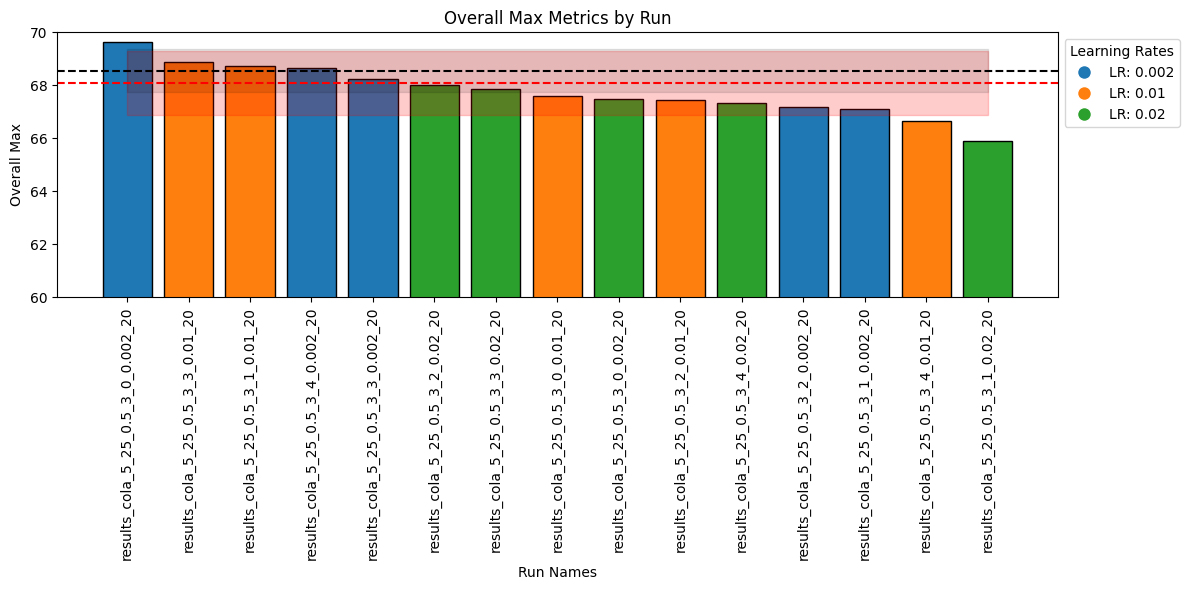

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# Assume run_max_metrics contains the data
sorted_results = sorted(run_max_metrics, key=lambda x: x["overall_max"], reverse=True)

# Extract data for plotting
run_names = [result['run_name'] for result in sorted_results]
overall_max = [result['overall_max'] for result in sorted_results]
learning_rates = [result['rank_allocation_learning_rate'] for result in sorted_results]

# Define baseline and its error
baseline_median = 68.08
baseline_std = 1.21

# Assign colors based on unique learning rates
unique_lrs = sorted(set(learning_rates))
color_map = {lr: plt.cm.tab10(i % 10) for i, lr in enumerate(unique_lrs)}
colors = [color_map[lr] for lr in learning_rates]

# Plotting the bar plot
plt.figure(figsize=(12, 6))
bar_positions = np.arange(len(run_names))
plt.bar(bar_positions, overall_max, color=colors, edgecolor='black')

rank_25_mediean=68.55
rank_25_std=0.81

# Add baseline with shading for std
plt.axhline(baseline_median, color='red', linestyle='--', label=f'Baseline: {baseline_median:.2f}')
plt.axhline(rank_25_mediean, color='black', linestyle='--', label=f'Baseline: {rank_25_mediean:.2f}')

plt.fill_between(bar_positions, baseline_median - baseline_std, baseline_median + baseline_std, color='red', alpha=0.2, label=f'Baseline ± std')
plt.fill_between(bar_positions, rank_25_mediean - rank_25_std, rank_25_mediean + rank_25_std, color='black', alpha=0.1, label=f'Rank 25 ± std')

# Adding labels and legend
plt.xticks(bar_positions, run_names, rotation=90)
plt.xlabel('Run Names')
plt.ylabel('Overall Max')
plt.title('Overall Max Metrics by Run')

# Create legend for learning rates
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'LR: {lr}', markerfacecolor=color_map[lr], markersize=10) for lr in unique_lrs]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title="Learning Rates")
plt.ylim(60, 70)  # Adjust the upper limit if needed

plt.tight_layout()
plt.show()
